<a href="https://colab.research.google.com/github/tushar15501/Face-Mask-Detector/blob/master/Face_Mask_Detector_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd 
import cv2
import random
import os
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline

import keras 
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras import layers, models, optimizers

# Loading the data

In [ ]:
mask_dir = '/content/drive/MyDrive/Face Mask Detection /with_mask'
no_mask_dir = '/content/drive/MyDrive/Face Mask Detection /without_mask'
mask_img = [f'{mask_dir}/{i}' for i in os.listdir(mask_dir)]
no_mask_img = [f'{no_mask_dir}/{i}' for i in os.listdir(no_mask_dir)]

In [ ]:
print("Total number of images with mask: " + str(len(mask_img)))
print("Total number of images without mask: " + str(len(no_mask_img)))
print("Total images: " + str(len(mask_img) + len(no_mask_img)))

Total number of images with mask: 1915
Total number of images without mask: 1918
Total images: 3833


# Splitting the data

In [ ]:
# Here the data is splitted into 80% train and 20% test.

tr_mask = mask_img[0:1499]
tr_no_mask = no_mask_img[0:1499]
test_mask = mask_img[1500:]
test_no_mask = no_mask_img[1500:]


In [ ]:
# Combining the training and testing sets

train_img = tr_mask + tr_no_mask
test_img = test_mask + test_no_mask

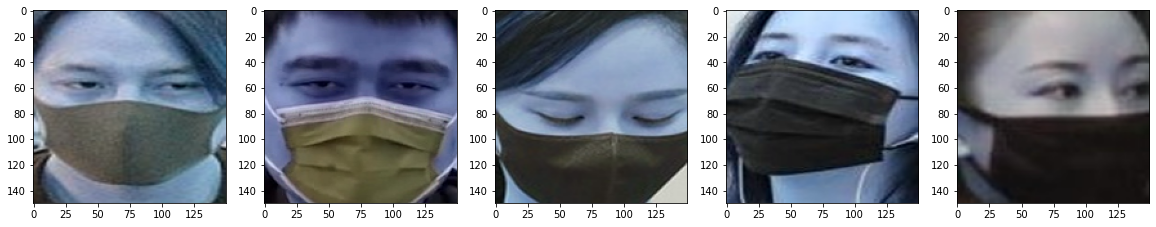

In [ ]:
# Defining  a function to resive and convert the images to the 3 channel BGR color image

# Also creating labels for with mask = 0 and without mask = 1 for classification use in neural network

def process_imgs(imgs, width=150, height=150):
    x = []
    y = []
    for i in imgs:
        x.append(cv2.resize(cv2.imread(i, cv2.IMREAD_COLOR), (width, height), interpolation=cv2.INTER_CUBIC))
        label = 1 if 'without' in i else 0
        y.append(label)
    return np.array(x), np.array(y)

tr_x, tr_y = process_imgs(train_img)
test_x, test_y = process_imgs(test_img)

# plot 5 images just to see the results of processing the images
plt.figure(figsize=(20, 10))
cols = 5
for i in range(cols):
    plt.subplot(5 / cols+1, cols, i+1) #keras
    plt.imshow(tr_x[i])




# Perfoming Image Augumentation

In [ ]:
tr_data = ImageDataGenerator(rescale=1/255,
                            rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True)

tr_gen = tr_data.flow(tr_x, tr_y, batch_size=32)
test_gen = tr_data.flow(test_x, test_y, batch_size = 32)

# Building First Model (Without Transfer Learning)

In [ ]:
model1 = models.Sequential()
model1.add(Conv2D(64, (1, 1), input_shape = (150,150,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Conv2D(128, (1, 1), activation='relu'))
model1.add(layers.Flatten())
model1.add(layers.Dense(256, activation='relu'))
model1.add(layers.Dense(2, activation='softmax'))

# Compiling the model

In [ ]:
batch_size = 32
epochs = 20
model1.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['acc'])
hist1 = model1.fit(tr_gen, steps_per_epoch=tr_x.shape[0] // batch_size, epochs=epochs)

Epoch 1/20
93/93 [==============================] - 22s 225ms/step - loss: 5.0989 - acc: 0.7583
Epoch 2/20
93/93 [==============================] - 21s 227ms/step - loss: 0.3240 - acc: 0.8833
Epoch 3/20
93/93 [==============================] - 21s 226ms/step - loss: 0.2726 - acc: 0.8877
Epoch 4/20
93/93 [==============================] - 21s 225ms/step - loss: 0.2635 - acc: 0.8972
Epoch 5/20
93/93 [==============================] - 21s 227ms/step - loss: 0.2518 - acc: 0.9026
Epoch 6/20
93/93 [==============================] - 21s 226ms/step - loss: 0.2535 - acc: 0.9005
Epoch 7/20
93/93 [==============================] - 21s 226ms/step - loss: 0.2433 - acc: 0.9086
Epoch 8/20
93/93 [==============================] - 21s 225ms/step - loss: 0.2376 - acc: 0.9117
Epoch 9/20
93/93 [==============================] - 21s 225ms/step - loss: 0.2310 - acc: 0.9110
Epoch 10/20
93/93 [==============================] - 21s 228ms/step - loss: 0.2204 - acc: 0.9086
Epoch 11/20
93/93 [====================

In [ ]:
# Comparing the accuracy and loss on test data

results1 = model1.evaluate(test_gen, batch_size = 32)
print("Test loss and test accuracy: ", results1)

27/27 [==============================] - 5s 175ms/step - loss: 0.2202 - acc: 0.9076
Test loss and test accuracy:  [0.22021789848804474, 0.9075630307197571]


# Visualizing the results

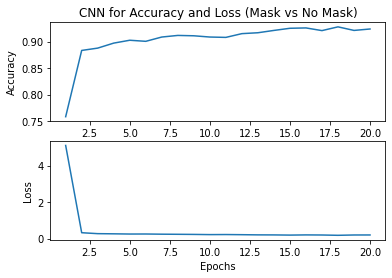

In [ ]:
epochs1 = list(range(1, len(hist1.history['acc'])+1))
accuracy1 = hist1.history['acc']
loss1 = hist1.history['loss']

plt.subplot(2,1,1)
plt.plot(epochs1, accuracy1)
plt.title("CNN for Accuracy and Loss (Mask vs No Mask)")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.subplot(2,1,2)
plt.plot(epochs1, loss1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Second Model (With Transfer Learning)

In [ ]:
#Loading pre-trained weights from ImageNet to save training time, with the help of transfer learning

base=InceptionResNetV2(input_shape = (150,150,3) , weights = 'imagenet' , include_top = False)

In [ ]:
model2 = models.Sequential()
model2.add(base)
model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(2, activation='softmax'))
base.trainable = False

In [ ]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 3, 3, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten_3 (Flatten)         (None, 13824)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               3539200   
                                                                 
 dense_7 (Dense)             (None, 2)                 514       
                                                                 
Total params: 57,876,450
Trainable params: 3,539,714
Non-trainable params: 54,336,736
_________________________________________________________________


In [ ]:
batch_size = 32
epochs = 20
model2.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['acc'])
hist2 = model2.fit(tr_gen, steps_per_epoch=tr_x.shape[0] // batch_size, epochs=epochs)

Epoch 1/20
93/93 [==============================] - 35s 246ms/step - loss: 0.7357 - acc: 0.9349
Epoch 2/20
93/93 [==============================] - 23s 245ms/step - loss: 0.2474 - acc: 0.9545
Epoch 3/20
93/93 [==============================] - 23s 245ms/step - loss: 0.1826 - acc: 0.9626
Epoch 4/20
93/93 [==============================] - 23s 245ms/step - loss: 0.1149 - acc: 0.9690
Epoch 5/20
93/93 [==============================] - 23s 246ms/step - loss: 0.0940 - acc: 0.9703
Epoch 6/20
93/93 [==============================] - 23s 245ms/step - loss: 0.1110 - acc: 0.9636
Epoch 7/20
93/93 [==============================] - 23s 246ms/step - loss: 0.0753 - acc: 0.9767
Epoch 8/20
93/93 [==============================] - 23s 246ms/step - loss: 0.0684 - acc: 0.9757
Epoch 9/20
93/93 [==============================] - 23s 248ms/step - loss: 0.0619 - acc: 0.9781
Epoch 10/20
93/93 [==============================] - 23s 245ms/step - loss: 0.0586 - acc: 0.9794
Epoch 11/20
93/93 [====================

In [ ]:
results2 = model2.evaluate(test_gen, batch_size = 32)
print("Test loss and test accuracy: ", results2)

27/27 [==============================] - 10s 239ms/step - loss: 0.0799 - acc: 0.9772
Test loss and test accuracy:  [0.07992155849933624, 0.9771908521652222]


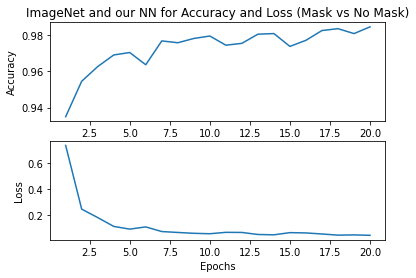

In [ ]:
epochs2 = list(range(1, len(hist2.history['acc'])+1))
accuracy2 = hist2.history['acc']
loss2 = hist2.history['loss']


plt.subplot(2,1,1)
plt.plot(epochs2, accuracy2)
plt.title("ImageNet and our NN for Accuracy and Loss (Mask vs No Mask)")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.subplot(2,1,2)
plt.plot(epochs2, loss2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()